In [93]:
# pip install scikit-fuzzy

In [94]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
from scipy.integrate import quad
from scipy import integrate
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random

In [95]:
# Defining the dataset

def generate_data(n=5000, seed=0, beta1=1.05, alpha1=0.4, alpha2=0.3):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    bloodpressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    return pd.DataFrame({'bloodpressure': bloodpressure, 'sodium': sodium,
                         'age': age})

data = generate_data(n=5000, seed=0, beta1=1.05, alpha1=0.4, alpha2=0.3)
data

,bloodpressure,sodium,age
0,152.069798,4.410849,73.820262
1,136.302391,2.984810,67.000786
2,143.984346,2.346063,69.893690
3,156.454474,3.671327,76.204466
4,151.154654,2.530366,74.337790
...,...,...,...
4995,131.477051,1.773670,64.493128
4996,143.359459,3.860877,68.733329
4997,144.650306,4.386089,69.645909
4998,135.537161,3.641918,66.147090


In [96]:
Data = data.copy(deep=True)

In [97]:
num_fuzzy_sets = 8
num_intervals  = num_fuzzy_sets -1
# Partitioning the domain of each variable to define fuzzy sets
# Here, 'variable' is a column of our dataset such as data['column']

c = 0.2
def partition(variable, i):
  min = variable.min()
  max = variable.max()
  return  min + i*(max - min)/num_intervals

def membership_function(variable, i, x):
  if i == 0:
    point_1 = partition(variable, i)
    point_2 = partition(variable, i + 2)
    mean = point_1
    std = c*(point_2 - point_1)
    return np.where(point_1 <= x, np.exp(-((x - mean)**2)/(2*(std**2))), 1)
  elif i == num_intervals:
    point_1 = partition(variable, i - 2)
    point_2 = partition(variable, i )
    mean = point_2
    std = c*(point_2 - point_1)
    return np.where(x <= point_2, np.exp(-((x - mean)**2)/(2*(std**2))), 1)
  else:
    point_1 = partition(variable, i - 1)
    point_2 = partition(variable, i)
    point_3 = partition(variable, i + 1)
    mean = point_2
    std = c*(point_3 - point_1)
    return np.exp(-((x - mean)**2)/(2*(std**2)))

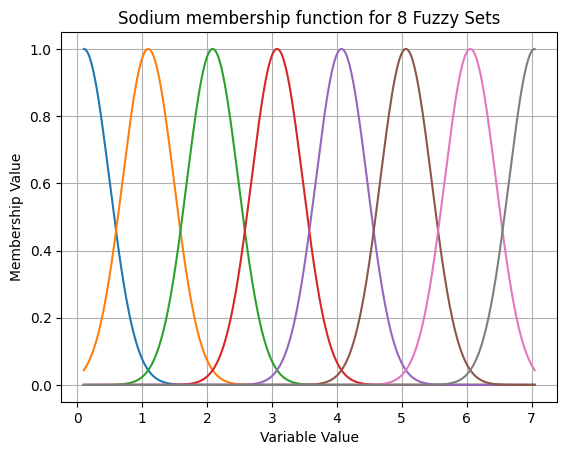

In [98]:
# Generate a range of x values
x_values = np.linspace(data['sodium'].min(), data['sodium'].max(), 500)

# Select the fuzzy set index i to plot
# i = 3  # For example, plot the membership function for the third fuzzy set

for i in range(num_fuzzy_sets):
  # Compute membership values
  membership_values = membership_function(data['sodium'], i, x_values)

  # Plotting
  plt.plot(x_values, membership_values)
plt.title(f'Sodium membership function for {num_fuzzy_sets} Fuzzy Sets')
plt.xlabel('Variable Value')
plt.ylabel('Membership Value')
plt.grid(True)
plt.show()

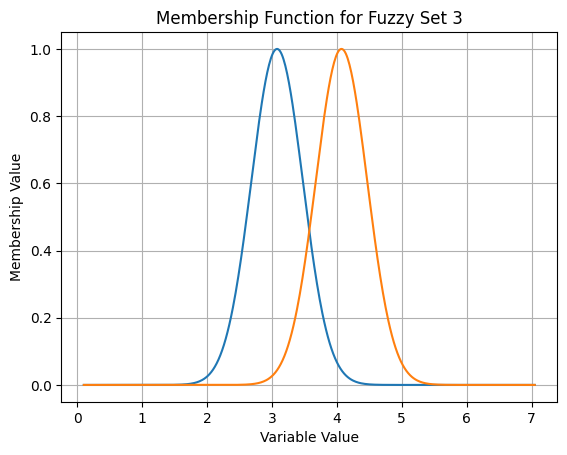

In [99]:
# Generate a range of x values
x_values = np.linspace(data['sodium'].min(), data['sodium'].max(), 500)

# Select the fuzzy set index i to plot
i = 3  # For example, plot the membership function for the third fuzzy set

# Compute membership values
membership_values = membership_function(data['sodium'], i, x_values)
membership_values1 = membership_function(data['sodium'], 4, x_values)
# print(membership_values)
# Plotting
plt.plot(x_values, membership_values)
plt.plot(x_values, membership_values1)
plt.title(f'Membership Function for Fuzzy Set {i}')
plt.xlabel('Variable Value')
plt.ylabel('Membership Value')
plt.grid(True)
plt.show()

In [100]:
def apply_and_replace(variable, x):
    max_result = -float('inf')  # Initialize with negative infinity
    max_index = -1  # Initialize index
    for i in range(num_fuzzy_sets):
        result = membership_function(variable, i, x)
        if result > max_result:
            max_result = result
            max_index = i
    return max_index

df = Data.to_numpy()

Data['bloodpressure'] = Data['bloodpressure'].apply(lambda x: apply_and_replace(Data['bloodpressure'], x))
Data['sodium'] = Data['sodium'].apply(lambda x: apply_and_replace(Data['sodium'], x))
Data['age'] = Data['age'].apply(lambda x: apply_and_replace(Data['age'], x))
Data

,bloodpressure,sodium,age
0,5,4,5
1,4,3,4
2,4,2,4
3,5,4,6
4,5,2,5
...,...,...,...
4995,3,2,3
4996,4,4,4
4997,4,4,4
4998,4,4,4


In [101]:
from mlxtend.frequent_patterns import apriori, association_rules

# Encode categorical data (convert to binary format)
data_encoded = pd.get_dummies(Data, columns=['bloodpressure', 'sodium', 'age'])

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(data_encoded, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# List of all blood pressure related items
levels = list(np.arange(1, num_fuzzy_sets))
bloodpressure_items = [f'bloodpressure_{level}' for level in levels]

# Filter rules where all items in the consequents are blood pressure related
bloodpressure_only_rules = rules[rules['consequents'].apply(lambda x: all(item in bloodpressure_items for item in x))]
rules_with_one_element = bloodpressure_only_rules[bloodpressure_only_rules['antecedents'].apply(lambda x: len(x) == 1)]
rules_with_two_elements = bloodpressure_only_rules[bloodpressure_only_rules['antecedents'].apply(lambda x: len(x) == 2)]

def transform_item(item):
    # Split the item into parts and handle cases with more than one underscore
    parts = item.split('_')
    if len(parts) > 2:
        # Rejoin all parts except the last as the variable name
        variable = '_'.join(parts[:-1])
        value = parts[-1]
    else:
        variable, value = parts

    # Return the transformed item as a normal text string
    return f"{variable}['{value}']"

def transform_rule_set(rule_set):
    # Transform each item in the set
    return set(transform_item(item) for item in rule_set)

# Apply the transformation to your filtered rules
for d in [rules_with_one_element, rules_with_two_elements]:
    d['antecedents'] = d['antecedents'].apply(transform_rule_set)
    d['consequents'] = d['consequents'].apply(transform_rule_set)

# Extracting an example
antecedents = list(rules_with_two_elements.iloc[0]['antecedents'])
consequents = list(rules_with_two_elements.iloc[0]['consequents'])

# First antecedent as a normal text string
antecedent_text = antecedents[0]
print(antecedent_text)
type(antecedent_text)

sodium['2']


str

In [102]:
rules_with_two_elements

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
52,"{sodium['2'], age['2']}",{bloodpressure['2']},0.0276,0.1514,0.0246,0.891304,5.887083,0.020421,7.807120,0.853699
56,"{sodium['2'], age['3']}",{bloodpressure['2']},0.0612,0.1514,0.0100,0.163399,1.079252,0.000734,1.014342,0.078219
62,"{sodium['3'], age['2']}",{bloodpressure['2']},0.0534,0.1514,0.0524,0.981273,6.481330,0.044315,45.315240,0.893419
69,"{sodium['4'], age['2']}",{bloodpressure['2']},0.0374,0.1514,0.0342,0.914439,6.039884,0.028538,9.918012,0.866854
72,"{sodium['2'], age['3']}",{bloodpressure['3']},0.0612,0.3800,0.0512,0.836601,2.201582,0.027944,3.794400,0.581361
81,"{age['3'], sodium['3']}",{bloodpressure['3']},0.1372,0.3800,0.1262,0.919825,2.420592,0.074064,7.733091,0.680202
88,"{sodium['4'], age['3']}",{bloodpressure['3']},0.1148,0.3800,0.1060,0.923345,2.429855,0.062376,8.088182,0.664768
92,"{sodium['5'], age['3']}",{bloodpressure['3']},0.0428,0.3800,0.0376,0.878505,2.311854,0.021336,5.103077,0.592819
96,"{sodium['2'], age['4']}",{bloodpressure['4']},0.0366,0.3364,0.0250,0.683060,2.030500,0.012688,2.093772,0.526791
101,"{sodium['3'], age['4']}",{bloodpressure['4']},0.1074,0.3364,0.0904,0.841713,2.502120,0.054271,4.192391,0.672573


In [103]:
min_sodium = data['sodium'].min()
min_age = data['age'].min()
min_bloodpressure = data['bloodpressure'].min()

max_sodium = data['sodium'].max()
max_age = data['age'].max()
max_bloodpressure = data['bloodpressure'].max()

num_points = 100
step_sodium = (max_sodium - min_sodium)/num_points
step_age = (max_age - min_age)/num_points
step_bloodpressure = (max_bloodpressure - min_bloodpressure)/num_points


sodium = ctrl.Antecedent(np.arange(min_sodium, max_sodium  , step_sodium), 'sodium')
age = ctrl.Antecedent(np.arange(min_age, max_age  , step_age), 'age')
bloodpressure = ctrl.Consequent(np.arange(min_bloodpressure, max_bloodpressure  , step_bloodpressure), 'bloodpressure')

c = 0.2

#sodium
for i in range(num_fuzzy_sets):
  string = str(i)
  if i == 0:
    point_1 = partition(data['sodium'], i)
    point_2 = partition(data['sodium'], i + 1)
    sodium[string] = fuzz.gaussmf(sodium.universe, point_1, c*(point_2 - point_1))
  elif i == num_intervals:
    point_1 = partition(data['sodium'], i - 1)
    point_2 = partition(data['sodium'], i )
    sodium[string] = fuzz.gaussmf(sodium.universe, point_2, c*(point_2 - point_1))
  else:
    point_1 = partition(data['sodium'], i - 1)
    point_2 = partition(data['sodium'], i)
    point_3 = partition(data['sodium'], i + 1)
    sodium[string] = fuzz.gaussmf(sodium.universe, point_2, c*(point_3 - point_2))

#age
for i in range(num_fuzzy_sets):
  string = str(i)
  if i == 0:
    point_1 = partition(data['age'], i)
    point_2 = partition(data['age'], i + 1)
    age[string] = fuzz.gaussmf(age.universe, point_1, c*(point_2 - point_1))
  elif i == num_intervals:
    point_1 = partition(data['age'], i - 1)
    point_2 = partition(data['age'], i )
    age[string] = fuzz.gaussmf(age.universe, point_2, c*(point_2 - point_1))
  else:
    point_1 = partition(data['age'], i - 1)
    point_2 = partition(data['age'], i)
    point_3 = partition(data['age'], i + 1)
    age[string] = fuzz.gaussmf(age.universe, point_2, c*(point_3 - point_1))

#bloodpressure
for i in range(num_fuzzy_sets):
  string = str(i)
  if i == 0:
    point_1 = partition(data['bloodpressure'], i)
    point_2 = partition(data['bloodpressure'], i + 1)
    bloodpressure[string] = fuzz.gaussmf(bloodpressure.universe, point_1, c*(point_2 - point_1))
  elif i == num_intervals:
    point_1 = partition(data['bloodpressure'], i - 1)
    point_2 = partition(data['bloodpressure'], i )
    bloodpressure[string] = fuzz.gaussmf(bloodpressure.universe, point_2, c*(point_2 - point_1))
  else:
    point_1 = partition(data['bloodpressure'], i - 1)
    point_2 = partition(data['bloodpressure'], i)
    point_3 = partition(data['bloodpressure'], i + 1)
    bloodpressure[string] = fuzz.gaussmf(bloodpressure.universe, point_2, c*(point_3 - point_2))

# Define the rules

def parse_fuzzy_reference(reference_str, namespace):
    parts = reference_str.split('[')
    var_name = parts[0]
    # Correctly strip quotes and extra characters
    set_name = parts[1].replace("'", "").replace('"', "").replace("]", "")
    return namespace[var_name][set_name]


# Namespace for fuzzy variables
namespace = {'sodium': sodium, 'age': age, 'bloodpressure': bloodpressure}

# Function to combine conditions with AND
def combine_conditions(conditions):
    combined = conditions[0]
    for cond in conditions[1:]:
        combined &= cond
    return combined

# Define the fuzzy rules
fuzzy_rules = []

# For rules with one element
#for i in range(len(rules_with_one_element)):
 #   antecedents = list(rules_with_one_element.iloc[i]['antecedents'])
 #   consequents = list(rules_with_one_element.iloc[i]['consequents'])
 #   rule = ctrl.Rule(parse_fuzzy_reference(antecedents[0], namespace), parse_fuzzy_reference(consequents[0], namespace))
  #  fuzzy_rules.append(rule)

# For rules with two elements
for i in range(len(rules_with_two_elements)):
    antecedents = list(rules_with_two_elements.iloc[i]['antecedents'])
    consequents = list(rules_with_two_elements.iloc[i]['consequents'])
    antecedent_conditions = [parse_fuzzy_reference(ant, namespace) for ant in antecedents]
    rule = ctrl.Rule(combine_conditions(antecedent_conditions), parse_fuzzy_reference(consequents[0], namespace))
    fuzzy_rules.append(rule)

# For rules with three elements
#for i in range(len(rules_with_three_elements)):
#    antecedents = list(rules_with_three_elements.iloc[i]['antecedents'])
#    consequents = list(rules_with_three_elements.iloc[i]['consequents'])
#    antecedent_conditions = [parse_fuzzy_reference(ant, namespace) for ant in antecedents]
#    rule = ctrl.Rule(combine_conditions(antecedent_conditions), parse_fuzzy_reference(consequents[0], namespace))
#    fuzzy_rules.append(rule)


#rule1 = ctrl.Rule(sodium['medium'] & age['high'], bloodpressure['high'])
#rule2 = ctrl.Rule(proteinuria['high'] & age['high'], bloodpressure['high'])
#rule3 = ctrl.Rule(sodium['low'] & age['low'], bloodpressure['low'])
#rule4 = ctrl.Rule(sodium['low'] & proteinuria['low'], bloodpressure['low'])
#rule5 = ctrl.Rule(sodium['medium'] & age['low'], bloodpressure['low'])
#rule6 = ctrl.Rule(sodium['medium'] & proteinuria['low'], bloodpressure['low'])
#rule7 = ctrl.Rule(proteinuria['low'] & age['low'], bloodpressure['low'])
#rule8 = ctrl.Rule(sodium['low'] & age['medium'], bloodpressure['medium'])
#rule9 = ctrl.Rule(sodium['low'] & age['medium'], bloodpressure['medium'])
#rule10 = ctrl.Rule(sodium['low'] & proteinuria['medium'], bloodpressure['medium'])
#rule11 = ctrl.Rule(sodium['medium'] & age['medium'], bloodpressure['medium'])
#rule12 = ctrl.Rule(sodium['medium'] & proteinuria['medium'], bloodpressure['medium'])
#rule13 = ctrl.Rule(age['medium'] & proteinuria['medium'], bloodpressure['medium'])
#rule14 = ctrl.Rule(age['low'] & proteinuria['low'] & sodium['low'], bloodpressure['medium'])
#rule15 = ctrl.Rule(age['low'] & proteinuria['low'] & sodium['low'], bloodpressure['low'])
#rule16 = ctrl.Rule(age['medium'] & proteinuria['medium'] & sodium['medium'], bloodpressure['medium'])
# Create the control system
#bloodpressure_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13,rule14,rule15, rule16])
bloodpressure_ctrl = ctrl.ControlSystem(fuzzy_rules)
# Create a simulation
bloodpressure_simulation = ctrl.ControlSystemSimulation(bloodpressure_ctrl)

# Input values (food quality and service quality)
sodium_value = 4.657088
age_value = 73.820262

# Pass input values to the simulation
bloodpressure_simulation.input['sodium'] = sodium_value
bloodpressure_simulation.input['age'] = age_value
# Calculate the bloodpressure
bloodpressure_simulation.compute()

# Print the result
print("Estimated bloodpressure amount:", bloodpressure_simulation.output['bloodpressure'])

Estimated bloodpressure amount: 149.71607849447523


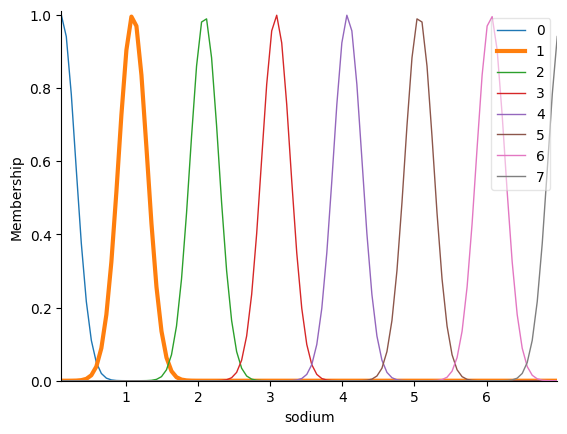

In [104]:
sodium['1'].view()

In [105]:
dff = data.copy(deep=True)
dff = dff.to_numpy()
ar = np.zeros(len(df))

for i in range(len(df)):
  sodium_value = dff[i][1]
  age_value = dff[i][2]
  bloodpressure_simulation.input['sodium'] = sodium_value
  bloodpressure_simulation.input['age'] = age_value
  bloodpressure_simulation.compute()
  ar[i] = bloodpressure_simulation.output['bloodpressure']

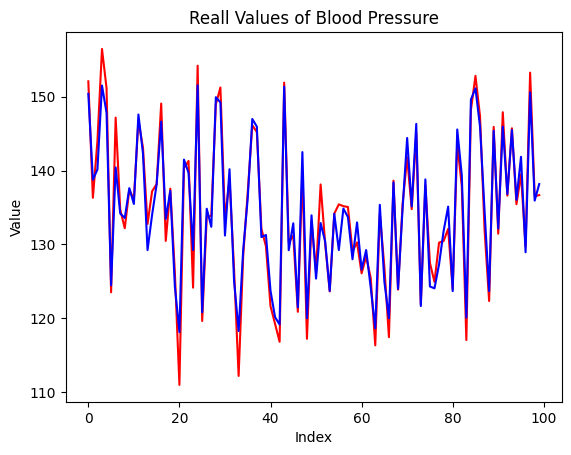

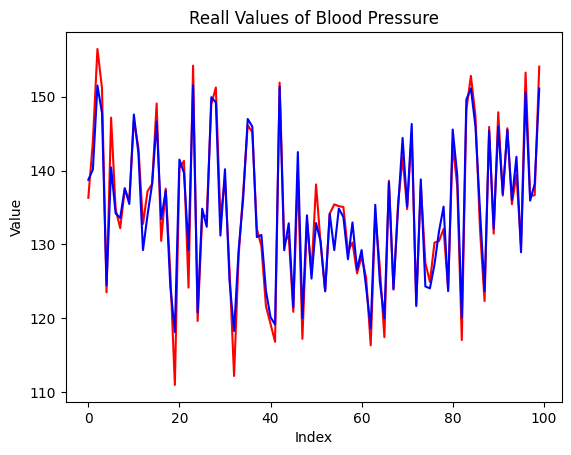

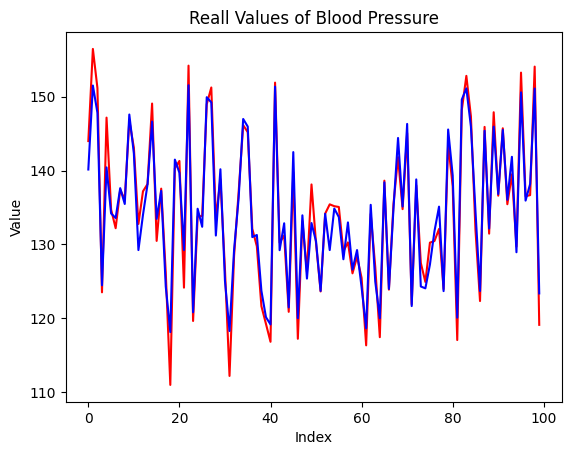

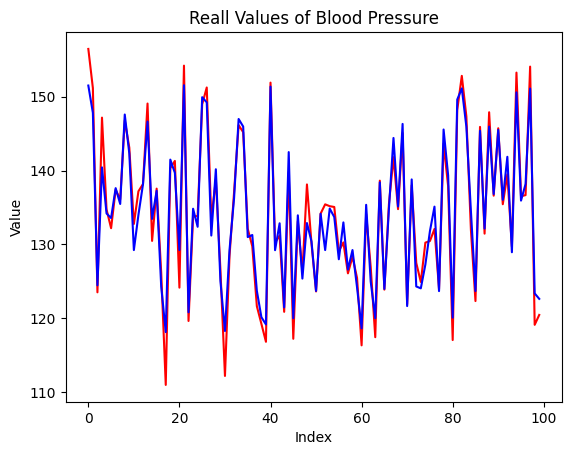

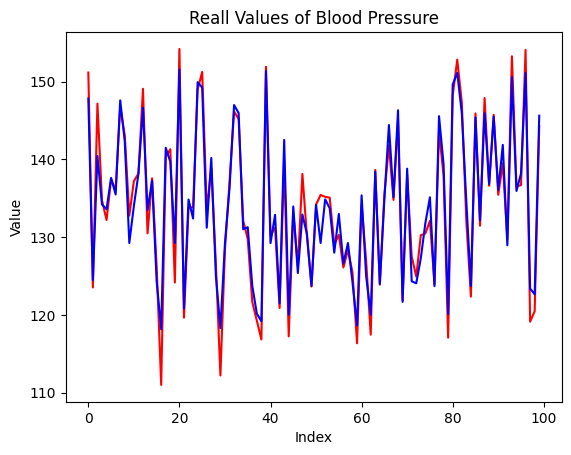

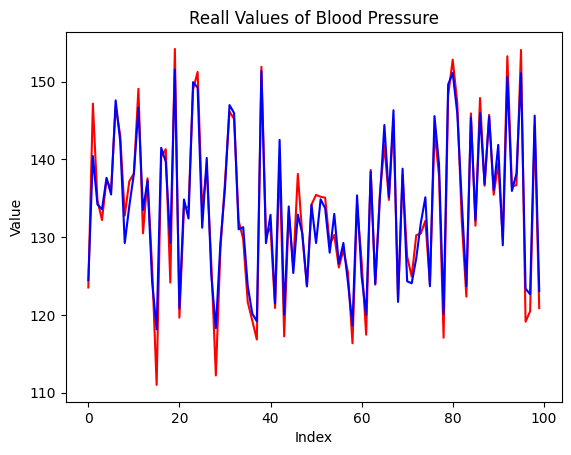

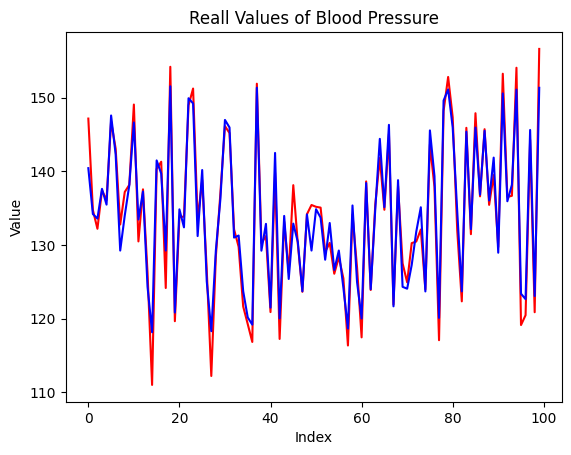

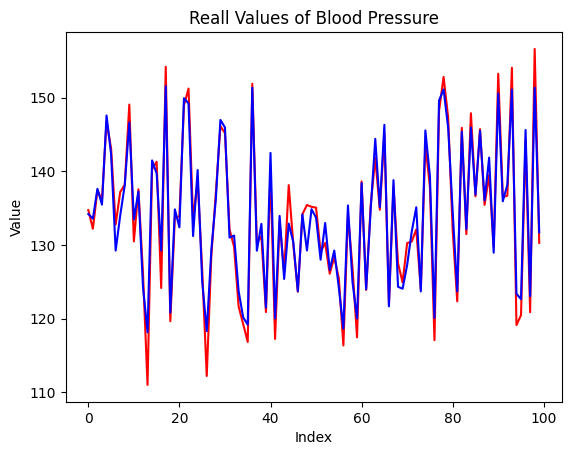

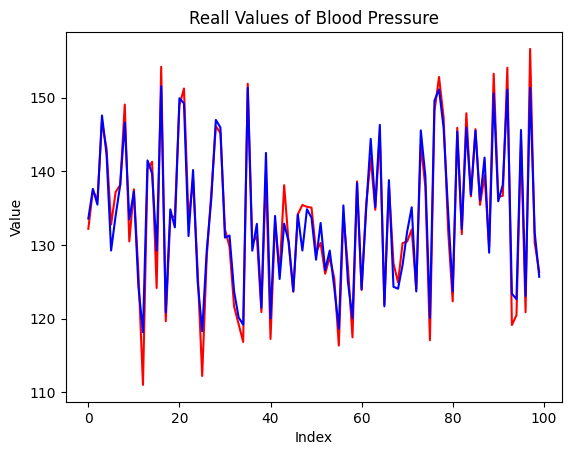

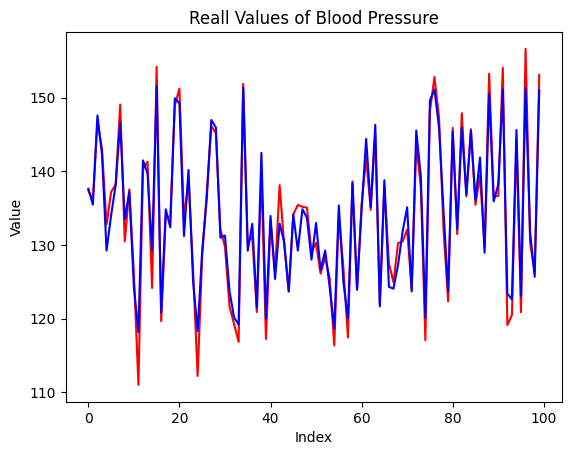

In [106]:
for i in range(10):
  plt.plot(dff[i:i+100,0], color = 'r')
  plt.plot(ar[i:i+100], color = 'b')
  plt.title('Reall Values of Blood Pressure')
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.show()